In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [3]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

raw data dim: (237, 15284)
Rep9_processing: (234, 14109)


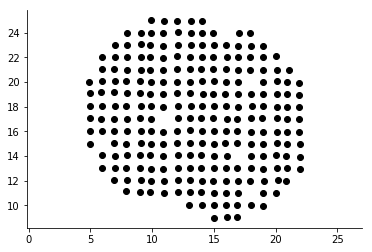

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep9_result_df.csv
(180,)
(327, 241)
(142, 19)
raw data dim: (281, 16416)
Rep10_processing: (278, 14764)


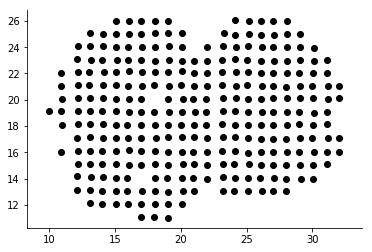

Saved: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep10_result_df.csv
(909,)
(1330, 285)
(607, 19)
raw data dim: (262, 16218)
Rep11_processing: (259, 14639)


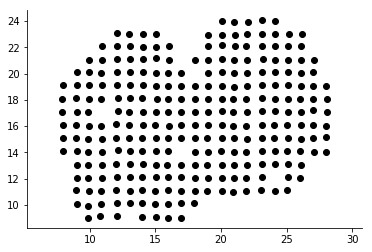

In [ ]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from io_utils import save_data_to_file, load_data_from_file
from main_methods import select_spatial_genes

def load_replicate_result(j, cache=True):
    # load the data for a given replicate
    ddir = '/Users/jjzhu/Google Drive/_GLISS/data/scGCO'
    ff = ddir + '/data/Raw_data/MOB-breast-cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
    locs,data=read_spatial_expression(ff,sep='\t')
    data_norm = normalize_count_cellranger(data)
    print('Rep{}_processing: {}'.format(j,data_norm.shape))
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.scatter(*locs.T, c='k')
    plt.axis('equal')
    plt.show()
    alpha= 0.01
    
    fn =  ddir+'/data/MouseOB/our_results/Rep'+ str(j)+'_result_df.csv'
    if cache and os.path.exists(fn):
        result = load_data_from_file(fn, 'csv')
        rej_idx = result.loc[result['reject']].index
        print('Loaded: {}'.format(fn))
        ours = result.geneID[rej_idx]
    else:
        # run our method
        pvals, rej_idx = select_spatial_genes(locs, 
                                              data_norm.values, 
                                              alpha=alpha,
                                              n_perm=100000)
        reject = np.array([False] * len(pvals))
        reject[rej_idx] = True
        result = pd.DataFrame({'pvalue': pvals, 'reject': reject, 
                               'geneID':data_norm.columns}, 
                               index=data_norm.columns)
        # save result to file
        save_data_to_file(result, fn, 'csv')        
        print('Saved: {}'.format(fn))
        ours = data_norm.columns[rej_idx]
    
    print(ours.shape)

    # load scgco result
    fn = ddir+'/data/MouseOB/scGCO_results/Rep'+ str(j)+'_result_df.csv'
    gco_df = pd.read_csv(fn, index_col=0)
    gco_df = gco_df.loc[gco_df['fdr'] < alpha]
    print(gco_df.shape)

    # load spatial de result
    de_df=pd.read_csv(ddir+'/data/MouseOB/spatialDE_results/Rep'+ str(j)+'_MOB_results.csv')
    de_df=de_df[de_df.qval<0.05]
    de_df=de_df.query("g!='log_total_count'")
    print(de_df.shape)
    
    return {
        'scGCO': set(gco_df.index),
        'SpatialDE': set(de_df.g.values),
        'Ours': set(ours)
    }
res = {}
for v in [9, 10, 11]:
    res[v] = load_replicate_result(v, cache=False)